# This file can be used to test functions or bugs with 1 agent at a fixed spawn location

In [6]:
# import libraries
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation
import mesa
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import numpy as np
import math
from IPython.display import HTML
from matplotlib import rc
import pandas as pd
import numpy.lib.recfunctions as rf
from queue import Queue
import collections
import time
import sys

rngbeta = np.random.default_rng()
rngspeed = np.random.default_rng()

# TODO: Make elevators work (agent)
# TODO: Create input file (instead of class input)
# TODO: Possibly create following behaviour between navigation agents
# TODO: Change different agent spawn rules
# TODO: fix bug near lab exit (spawn 61, 27); Vision to exits broken by obstacles

This code runs with mesa version 3.00 or higher

In [7]:
# check mesa version
print("Mesa version: ", mesa.__version__)

Mesa version:  3.1.0


In [8]:
# Function to calculate Euclidean distance (distance between two points)
def euclidean_distance(pos1, pos2):
    # Use the formula to calculate distance between two coordinates
    return math.sqrt((pos1[0] - pos2[0]) ** 2 + (pos1[1] - pos2[1]) ** 2)

# Function to calculate integer grid points between two coordinates
def connect2(ends):
    d0, d1 = np.diff(ends, axis=0)[0]
    if np.abs(d0) > np.abs(d1): 
        return np.c_[np.arange(ends[0, 0], ends[1,0] + np.sign(d0), np.sign(d0), dtype=np.int32),
                     np.arange(ends[0, 1] * np.abs(d0) + np.abs(d0)//2,
                               ends[0, 1] * np.abs(d0) + np.abs(d0)//2 + (np.abs(d0)+1) * d1, d1, dtype=np.int32) // np.abs(d0)]
    else:
        return np.c_[np.arange(ends[0, 0] * np.abs(d1) + np.abs(d1)//2,
                               ends[0, 0] * np.abs(d1) + np.abs(d1)//2 + (np.abs(d1)+1) * d0, d0, dtype=np.int32) // np.abs(d1),
                     np.arange(ends[0, 1], ends[1,1] + np.sign(d1), np.sign(d1), dtype=np.int32)]

# Transforms the raw model grid data into usable arrays for the unblocked vision function
def prep_vision(vision_area, obstacles):
    # Find all obstacles within the vision range
    vision_array = np.asarray(vision_area)
    obstacles = np.asarray(obstacles)
    nrows, ncols = vision_array.shape
    dtype={'names':['f{}'.format(i) for i in range(ncols)], 'formats':ncols * [vision_array.dtype]}
    obstacles_in_sight = np.intersect1d(vision_array.view(dtype), obstacles.view(dtype))
    obstacles_in_sight = rf.structured_to_unstructured(obstacles_in_sight).tolist()
    
    # Trim vision_array down to only the edges (optimisation)
    xtrim = np.array([np.min(vision_array[:, 0]), np.max(vision_array[:, 0])])
    ytrim = np.array([np.min(vision_array[:, 1]), np.max(vision_array[:, 1])])
    
    xmask = np.isin(element = vision_array[:, 0], test_elements=xtrim)
    ymask = np.isin(element = vision_array[:, 1], test_elements=ytrim)
    
    xarray = vision_array[xmask]
    yarray = vision_array[ymask]
    vision_array = np.vstack((xarray, yarray))
    
    return vision_array, obstacles_in_sight

# Function to find all visible tiles to an agent around obstacles; call this function for enhanced vision behaviour
def unblocked_vision(pos, vision_area, obstacles):
    # Prepare data
    vision_array, obstacles_in_sight = prep_vision(vision_area, obstacles)
    x0 = pos[0]
    y0 = pos[1]
    vis_area = []
    
    # Iterate over all the tiles within the vision area
    for tile in vision_array[:, 0:2]:
        x1 = tile[0]
        y1 = tile[1]
        # Calculate simple sightline for straight lines (2D array); not covered by function
        if x0 == x1:
            if y0 > y1:
                liny = np.vstack(np.arange(y1, y0 + 1)[::-1])
            else:
                liny = np.vstack(np.arange(y0, y1 + 1))
            linx = (np.ones((len(liny[:, 0]), 1))*x0).astype(int)
            visline = np.hstack((linx, liny))
        elif y0 == y1:
            if x0 > x1:
                linx = np.vstack(np.arange(x1, x0 + 1)[::-1])
            else:
                linx = np.vstack(np.arange(x0, x1 + 1))
            liny = (np.ones((len(linx[:, 0]), 1))*y0).astype(int)
            visline = np.hstack((linx, liny))
            
        # Use function to obtain sightline for diagonals (2D array)
        else:
            coords = np.array([[x0, y0],
                               [x1, y1]])
            visline = connect2(coords)
        
        # Add all possible sighted tiles (not blocked by an obstacle) to new vision list of tuples
        for loc in visline[:, 0:2]:
            vis_area.append((int(loc[0]), int(loc[1])))
            if [loc[0], loc[1]] in obstacles_in_sight:
                break
                
    # Remove duplicates from the vision list
    vision_area = list(set(vis_area))
                
    return vision_area, obstacles_in_sight

# Tool to plot the vision area of a single agent; only use for development purposes
def plot_vision(pos, vision, obstacles, vision_area):
    viz = np.zeros((vision*2 + 1, vision*2 + 1))
    posx = pos[0] - vision
    posy = pos[1] - vision
    for i in range(len(viz[0, :])):
        for j in range(len(viz[:, 0])):
            y = vision*2 - j
            if (i + posx, j + posy) in vision_area:
                viz[y, i] = 1
            if (i + posx, j + posy) in obstacles:
                viz[y, i] = 2
            if (i + posx, j + posy) == pos:
                viz[y, i] = 3
                
    fig, ax = plt.subplots(figsize=(4, 4))
    cmap = mcolors.ListedColormap(['black', 'green', 'white', 'red'])
    bounds = [0, 1, 2, 3]
    norm = mcolors.BoundaryNorm(bounds, cmap.N, extend='max')
    ax.imshow(viz, cmap=cmap, norm=norm)

# Function that generates the shortest path in grid tile coordinates to a given index point on the grid
def exit_path(grid, pos, index):
    queue = collections.deque([[pos]])
    seen = set([pos])
    while queue:
        path = queue.popleft()
        x, y = path[-1]
        if grid[y][x] == index:
            return path
        for x2, y2 in ((x+1,y), (x-1,y), (x,y+1), (x,y-1)):
            if 0 <= x2 < len(grid[:, 0]) and 0 <= y2 < len(grid[0, :]) and grid[y2][x2] != 1 and (x2, y2) not in seen:
                queue.append(path + [(x2, y2)])
                seen.add((x2, y2))

# Function to generate the speed of an agent from the symmetric 2, 2 beta distribution
def beta_dist(lobound, hibound):
    # Get the randomly generated number and parameters for transformation
    speed = rngbeta.beta(2, 2)
    dfact = (hibound - lobound)

    # Transform to desired bounds and return float
    speed = speed*dfact+lobound

    return speed

# Convert a random speed number to a number of tiles moved through random number generation
def speed_convert(speed):
    # Move twice
    if rngspeed.uniform() < speed - 1 and speed >= 1:
        move = 2
    # Do not move
    elif rngspeed.uniform() < 1 - speed and speed < 1:
        move = 0
    # Normal; move once
    else:
        move = 1

    return move

# Base Model

In [21]:
###################
### AGENT CLASS ###
###################

# Define the NavigationAgent class
class NavigationAgent(Agent):
    def __init__(self, model, vision=5, real_vision = True, sign_vis = 0.38): # Default vision range of 5 cells
        super().__init__(model)  # MESA `Agent` class initialization, auto-assigns unique_id in Mesa 3.0
        # Attributes of each agent
        self.found_exit = False  # Track if agent has reached the exit
        self.previous_pos = None  # Previous position of the agent
        self.real_vision = real_vision
        self.vision = vision  # Vision range of the agent
        self.floor = None
        self.path = None
        self.changefloor = False
        self.can_see_sign = np.random.rand()
        self.sign_vis = sign_vis
        self.speed = beta_dist(0.8, 1.4)

    # Function to move the agent towards the exit
    def move_towards(self, locations, maxpop=8, moore=True):
        self.previous_pos = self.pos  # Store the current position before moving
        # MESA `get_neighborhood` function retrieves nearby cells based on vision range
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=moore, include_center=False)

        min_distance = float('inf')  # Start with a very large distance
        best_step = None  # Initialize best step as None

        # Check each possible step to find the one closest to the exit
        for step in possible_steps:
            # Only consider steps that don't have obstacles and have less than 8 agents
            if step not in self.model.obstacles and len(self.model.grid.get_cell_list_contents(step)) < maxpop:
                dist = []
                for loc in locations:
                    dist.append(euclidean_distance(step, loc))
                dist = np.min(dist)  # Distance to the exit
                if dist < min_distance:
                    min_distance = dist
                    best_step = step  # Update best step to be closer to the exit
        if best_step:
            # MESA `move_agent` function moves the agent to the new cell
            self.model.grid.move_agent(self, best_step)

    # Function to move the agent towards a desired exit based on memory or signs
    def move_to_exits(self):
        self.previous_pos = self.pos
        # Call and store new path if no path is set yet, else use set path to assigned exit
        if self.path and self.changefloor == False:
            path = self.path[1:]
            self.path = path
        else:
            # Decide whether to go for emergency or main exit
            if self.can_see_sign <= self.sign_vis:
                # Emergency exit indicator for path finding algorithm
                index = 4
            else:
                # Main entrance indicator for path finding algorithm
                index = 3
            path = exit_path(self.model.sgrid, self.pos, index)[1:]
            self.path = path
            self.changefloor = False
        # If there is a spot open in the desired path cell use that, else move to random cell
        if len(self.model.grid.get_cell_list_contents(path[0])) < 8:
            self.model.grid.move_agent(self, path[0])
        else:
            possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
            if self.floor == 0:
                valid_steps = [step for step in possible_steps if step not in self.model.obstacles and step not in self.model.stairs and len(self.model.grid.get_cell_list_contents(step)) < 8]
            else:
                valid_steps = [step for step in possible_steps if step not in self.model.obstacles and len(self.model.grid.get_cell_list_contents(step)) < 8]
            if valid_steps:
                # Randomly choose a valid position and move there
                random_step = self.random.choice(valid_steps)
                # MESA `move_agent` function moves the agent to the chosen position
                self.model.grid.move_agent(self, random_step)

    # Define the actions the agent will take in each step
    def step(self):
        move = speed_convert(self.speed)
        # If the agent is at the exit, mark as exited
        print("position", self.pos)
        if self.pos[1] > 63:
            self.floor = 1
        if self.pos[1] <= 63:
            self.floor = 0
        if self.pos in self.model.exit_location:
            self.found_exit = True  # Set the agent's exit status to True
            self.model.grid.remove_agent(self)  # MESA function to remove the agent from the grid
            self.remove()  #self.remove() to remove from AgentSet
            self.model.cumulative_exited += 1  # Count this agent in cumulative exited agents
        else:
            # MESA `get_neighborhood` checks the agent's vision area for the exit
            vision_area = self.model.grid.get_neighborhood(self.pos, moore=True, radius=self.vision, include_center=False)
            
            # Obtain all obstacles within the vision area (2D array)
            if self.real_vision:
                vision_area, obstacles_in_sight = unblocked_vision(self.pos, vision_area, self.model.obstacles)

            # Tool for visualisation of vision area 
            # ONLY USE WITH 1 AGENT AND 1 TIMESTEP
            # ------------------------------------ START -----------------------------------
            
            check_vis = True
            if check_vis:
                plot_vision(self.pos, self.vision, self.model.obstacles, vision_area)
            
            # ------------------------------------ END -----------------------------------
            # Find exits, stairs, floor area within vision range
            exits = []
            for loc in self.model.exit_location:
                if loc in vision_area:
                    exits.append(loc)
            exit_in_vision = exits

            signs = []
            for loc in self.model.signs:
                if loc in vision_area:
                    signs.append(loc)
            signs_in_vision = signs

            stairs = []
            for loc in self.model.stairs:
                if loc in vision_area:
                    stairs.append(loc)
            stairs_in_vision = stairs

            floor = []
            for loc in vision_area:
                if loc not in self.model.stairs and loc not in list(map(tuple, obstacles_in_sight)):
                    floor.append(loc)
            floor_in_vision = floor

            # Move towards the exit if it's in sight
            if exit_in_vision:
                self.move_towards(exit_in_vision)
            # Move down the stairs if on the stairs
            elif self.pos in self.model.stairs and self.floor == 1:
                self.model.grid.move_agent(self, (self.pos[0], self.pos[1]-67))
                self.floor = 0
                self.changefloor = True
            # Move towards stairs if in sight
            elif self.floor == 1 and stairs_in_vision:
                self.move_towards(stairs_in_vision)
            # If on the stairs on the ground floor, move away from stairs
            elif self.pos in self.model.stairs and self.floor == 0:
                self.move_towards(floor_in_vision, 2, moore=False)
            # Move to building main entrance or emergency exits if the agent can see signs
            else:
                self.move_to_exits()

###################
### MODEL CLASS ###
###################

# Define the model class to handle the overall environment
class FloorPlanModel(Model):
    def __init__(self, width, height, num_agents, agent_vision, agent_real_vision, sign_vis, spawn):
        super().__init__()  # `Model` class initialization
        
        # Basic model settings
        self.num_agents = num_agents
        self.agent_vision = agent_vision
        self.agent_real_vision = agent_real_vision
        self.grid = MultiGrid(width, height, False)  # MESA grid with dimensions; False means no wrapping
        self.static_grid = None
        self.sign_vis = sign_vis
        self.spawn_location = spawn
        
        # Define obstacles and signs in the grid
        floor0 = pd.read_csv("Floorplan_complex.csv", header=None)
        floor0 = pd.DataFrame.to_numpy(floor0)
        floor0 = np.flipud(floor0)

        GreenTiles = []
        BlackTiles = []
        WhiteTiles = []
        BlueTiles = []
        PurpleTiles = []
        YellowTiles = []
        OrangeTiles = []
        RedTiles = []
        
        for i in range(np.shape(floor0)[0]):
            for j in range(np.shape(floor0)[1]):
                if floor0[i, j] == 0:
                    GreenTiles.append((j, i))
                if floor0[i, j] == 1:
                    BlackTiles.append((j, i))
                if floor0[i, j] == 2:
                    WhiteTiles.append((j, i))
                if floor0[i, j] == 3:
                    BlueTiles.append((j, i))
                if floor0[i, j] == 4:
                    PurpleTiles.append((j, i))
                if floor0[i, j] == 5:
                    YellowTiles.append((j, i))
                if floor0[i, j] == 6:
                    OrangeTiles.append((j, i))
                if floor0[i, j] == 7:
                    RedTiles.append((j, i))

        self.outdoors = GreenTiles
        self.obstacles = BlackTiles
        self.indoors = WhiteTiles + BlueTiles
        self.exit_location = PurpleTiles
        self.stairs = YellowTiles
        self.lifts = OrangeTiles
        self.signs = RedTiles

        # Adapt grid for maze finding algorithm
        # Outside + obstacles = 1, Walking space = 2, entrance finding = 3, emergency exit finding = 4
        np.set_printoptions(threshold=sys.maxsize)
        floor0[floor0 == 0] = 1
        floor0[(floor0 == 3) | (floor0 == 6) | (floor0 == 7)] = 2
        topfloor = floor0[63:127]
        topfloor[topfloor == 5] = 4
        floor0[63:127] = topfloor
        floor0[30, 125] = 3
        floor0[90, 45] = 3
        self.sgrid = floor0
        
        # Initialize cumulative exited count
        self.cumulative_exited = 0

        # Initialize DataCollector (MESA tool for tracking metrics across steps)
        self.datacollector = DataCollector(
            model_reporters={
                "Active Agents": lambda m: len(m.agents),  # Count of agents still active
                "Exited Agents": lambda m: sum(1 for agent in m.agents if agent.found_exit == True),
                "Cumulative Exited Agents": lambda m: m.cumulative_exited,  # Cumulative exited count
                "Agents per Cell": self.count_agents_per_cell  # Counts agents in each cell
            },
            agent_reporters={
                "Found Exit": lambda a: a.found_exit if isinstance(a, NavigationAgent) else None  # Reports exit status per agent
            }
        )

        self.place_agents(agent_vision)  # Place agents on the grid
        self.datacollector.collect(self) # Collect data at the start of the simulation

    # Function to randomly place agents in the grid
    # TODO: Change spawn rules to for every tile type
    def place_agents(self, agent_vision):
        for i in range(self.num_agents):
            agent = NavigationAgent(self, vision=agent_vision, real_vision=self.agent_real_vision, sign_vis=self.sign_vis)
            placed = False  # Track if the agent is successfully placed
            while not placed:
                x = self.spawn_location[0]
                y = self.spawn_location[1]
                cell_contents = self.grid.get_cell_list_contents((x, y))

                # Only place agent if cell has no obstacles and fewer than 8 agents
                if (x, y) not in self.obstacles and len(cell_contents) < 8 and (x, y) not in self.outdoors and (x, y) not in self.stairs:
                    self.grid.place_agent(agent, (x, y))  # MESA function to place agent in grid
                    placed = True  # Mark as placed
                    # if you want to see the initial placement of the agents, uncomment the line below. This will print the initial position of the agents
                    # print(f"Agent {i} placed at: ({x}, {y})")

    # Function to count agents in each cell
    def count_agents_per_cell(self):
        agent_counts = {}  # Dictionary to store agent counts by cell position
        # MESA `coord_iter` function iterates over grid cells and their contents
        for cell in self.grid.coord_iter():
            cell_contents, (x, y) = cell  # Unpack cell contents and coordinates
            # Count NavigationAgents in each cell
            nav_agent_count = sum(1 for obj in cell_contents if isinstance(obj, NavigationAgent))
            if nav_agent_count > 0:
                agent_counts[(x, y)] = nav_agent_count
        return agent_counts
    
    # Function to get the grid data for visualization
    def get_grid(self):
        grid_data = np.zeros((self.grid.height, self.grid.width))
        # Mark obstacles on the grid
        for x, y in self.obstacles:
            grid_data[y, x] = 1
        for x, y in self.indoors:
            grid_data[y, x] = 2

        # Mark special areas on the grid
        for x, y in self.stairs:
            grid_data[y, x] = 5
        for x, y in self.lifts:
            grid_data[y, x] = 6

        # Mark agents on the grid
        for agent in self.agents:
            if isinstance(agent, NavigationAgent):
                x, y = agent.pos
                grid_data[y, x] = 8

        # Mark signs and exit
        for x, y in self.exit_location:
            grid_data[y, x] = 4
        for x, y in self.signs:
            grid_data[y, x] = 7
        self.static_grid = grid_data

        return grid_data

    # Model step function to update the simulation
    def step(self):
        self.agents.do("step")  # MESA 3.0 function to execute the `step` function of each agent
        self.datacollector.collect(self)  # MESA DataCollector collects metrics at each step



61 27
(61, 27)
(62, 27)
(63, 27)
(64, 27)
(65, 26)
(65, 27)
(66, 26)
(67, 25)
(68, 24)
(66, 27)


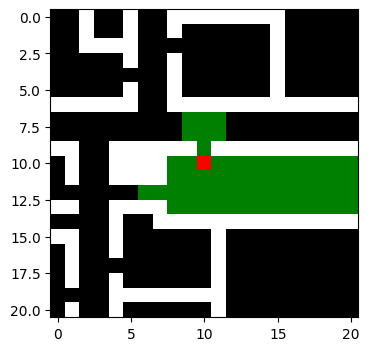

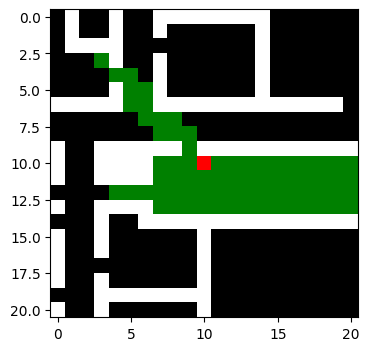

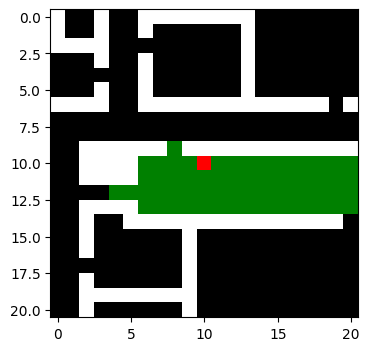

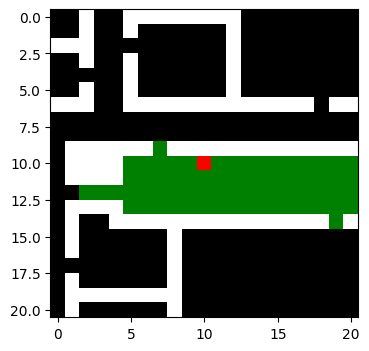

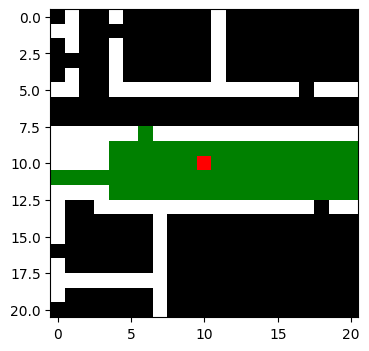

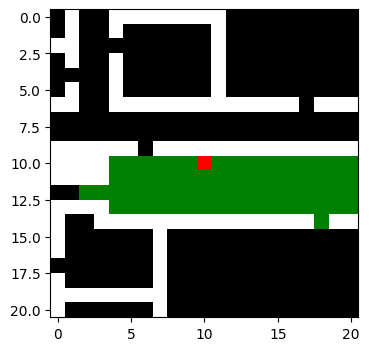

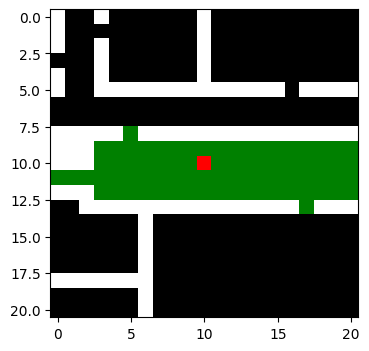

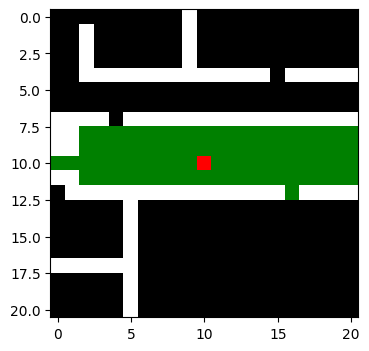

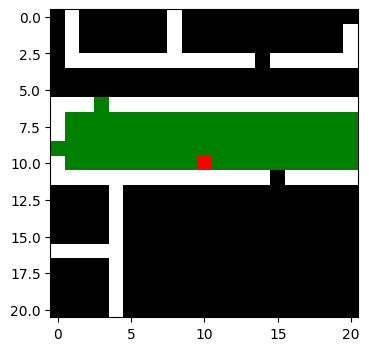

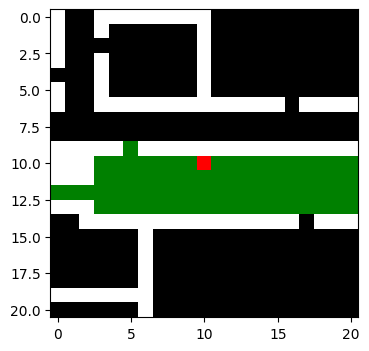

In [22]:
# Run the model and see the results
model = FloorPlanModel(127, 127, 1, 10, True, 0.38, (61, 27)) # run the model with 30x30 grid and 100 agents and a vision of 5
for i in range(10): # run the model for 100 steps
    model.step() # step the model by 1

# Collect the data from the model
model_data = model.datacollector.get_model_vars_dataframe()
agent_data = model.datacollector.get_agent_vars_dataframe()